In [1]:
import os
import math
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import display, HTML
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)

In [2]:
def get_output_dir():
    output_dir = './output_images'
    
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
        
    return output_dir

def get_doc_dir():
    output_dir = './output_images'
    
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
        
    return output_dir

def save_doc_img(img, name):
    mpimg.imsave(os.path.join(get_doc_dir(), name + '.jpg'), img)
    
def use_debug():
    return True

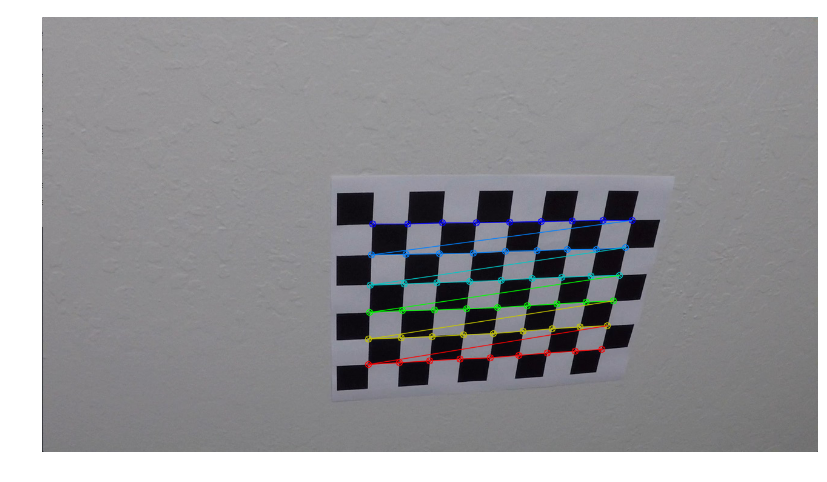

In [3]:
# Path to calibration images
calibration_images_paths = glob.glob('./camera_cal/*.jpg')

# Number of squares in X and Y direction
nx = 9
ny = 6

# Define object points for each image. We assume that each square
# has a size of 1 meter, and the origin is the top-left corner
# of the first square.
obj_pts_i = np.zeros((nx*ny, 3), np.float32)

# 0 to 8, not including 9

obj_pts_i[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Declare obj and img points
obj_pts = []
img_pts = []

plotted_img = False

# Loop over images
for img_path in calibration_images_paths:
    # Read image
    img = mpimg.imread(img_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Find checkboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # Add points to list
        img_pts.append(corners)
        obj_pts.append(obj_pts_i)
        
        # Draw resulting corners for the first image
        if not plotted_img:
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            plt.imshow(img);
            plt.axis('off');
            save_doc_img(img, 'checkerboard_corners')
            plotted_img = True

# Get the camera calibration coefficients and undistortion

In [4]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_pts, img_pts, gray.shape[::-1],None,None)

In [5]:
def undistort_img(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

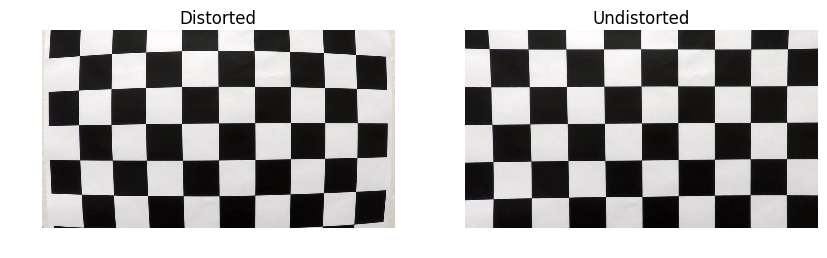

In [6]:
test_img = './camera_cal/calibration1.jpg'
img = mpimg.imread(test_img)
plt.subplot(1,2,1);
plt.imshow(img);
plt.title('Distorted')
plt.axis('off');
plt.subplot(1,2,2);
img_undistorted = undistort_img(img)
plt.imshow(undistort_img(img));
plt.title('Undistorted')
plt.axis('off');

# Save for documentation
save_doc_img(img, 'img_distorted')
save_doc_img(img_undistorted, 'img_undistorted')

In [7]:
# color mask, which can be used to do threshold in different color space or gradient in
# different orientation and return the binary image, which meet the requriements.
def mask_img(img, thresh):
    binary_output = np.zeros_like(img)
    binary_output[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return binary_output

def mask_to_rgb(img):
    return 255 * np.dstack((img, img, img))

def get_yellow_mask(img_hls):
    yellow_lower = np.array([15,50,100])
    yellow_upper = np.array([25,200,255])
    # // return the value in integer for the division operation 
    return cv2.inRange(img_hls, yellow_lower, yellow_upper) // 255
    
def get_white_mask(img_hls):
    white_lower = np.array([0,  200, 0])
    white_upper = np.array([255,255, 255])
    return cv2.inRange(img_hls, white_lower, white_upper) // 255

def get_saturation_mask(img, thresh=(100,255)):
    # Convert to HLS
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Create saturation mask
    s_mask = mask_img(img_hls[:,:,2], thresh)
    return s_mask

def compute_sobel(img, orient, sobel_kernel=3):
     # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    else:
        raise NotImplemented
    return sobel

def abs_sobel_mask(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Get sobel
    sobel = compute_sobel(img, orient)
        
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    return mask_img(scaled_sobel, thresh)
    
def mag_mask(img, sobel_kernel=3, thresh=(0, 255)):
    # Get sobel in X and Y directions
    sobel_x = compute_sobel(img, orient = 'x')
    sobel_y = compute_sobel(img, orient = 'y')
        
    # Take the absolute value of the derivative or gradient
    sobel_mag = np.sqrt(sobel_x * sobel_x + sobel_y * sobel_y)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    
    # Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    return mask_img(scaled_sobel, thresh)

def dir_mask(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Get sobel in X and Y directions
    sobel_x = compute_sobel(img, orient = 'x')
    sobel_y = compute_sobel(img, orient = 'y')
        
    # Calculate the absolute direction of the gradient 
    sobel_dir = np.absolute(np.arctan(sobel_y / (sobel_x + 1.e-7)))

    return mask_img(sobel_dir, thresh)

def combined_mask(img):
    # Color masks
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    yellow_mask = get_yellow_mask(img_hls)
    white_mask = get_white_mask(img_hls)
    
    color_mask = cv2.bitwise_or(yellow_mask, white_mask)
    
    # Gradient masks
    sobel_x_mask = abs_sobel_mask(img, orient = 'x', thresh=(25,255))

    # Final mask
    output_mask = cv2.bitwise_or(sobel_x_mask, color_mask)    
    sub_masks = [yellow_mask, white_mask, color_mask, sobel_x_mask]
    
    return output_mask, sub_masks


# employing the perspective transform

In [8]:
x1 = 195
x2 = 1090
y_horizon = 465
src_pts_ = ((x1, img.shape[0]),
            (x2, img.shape[0]),
            (705, y_horizon),
            (575, y_horizon))

off = 100 # Horizontal offset to have more space and better estimate sharp curves
dst_pts_ = ((x1 + off, img.shape[0]),
            (x2 - off, img.shape[0]),
            (x2 - off, 0),
            (x1 + off, 0))  

def get_birds_eye_view(img, src_pts=src_pts_, dst_pts=dst_pts_):
    img_size = (img.shape[1], img.shape[0])    
   
    M    = cv2.getPerspectiveTransform(np.float32(src_pts), np.float32(dst_pts))
    Minv = cv2.getPerspectiveTransform(np.float32(dst_pts), np.float32(src_pts))

    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR), M, Minv

# lane pixels detection

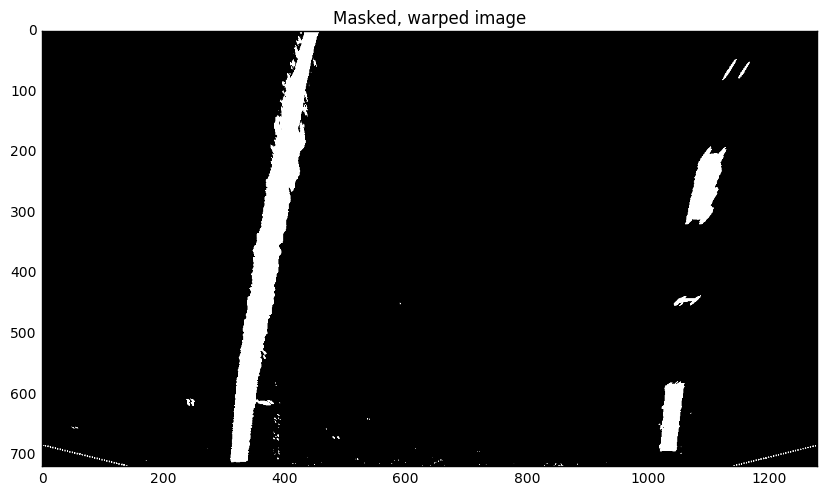

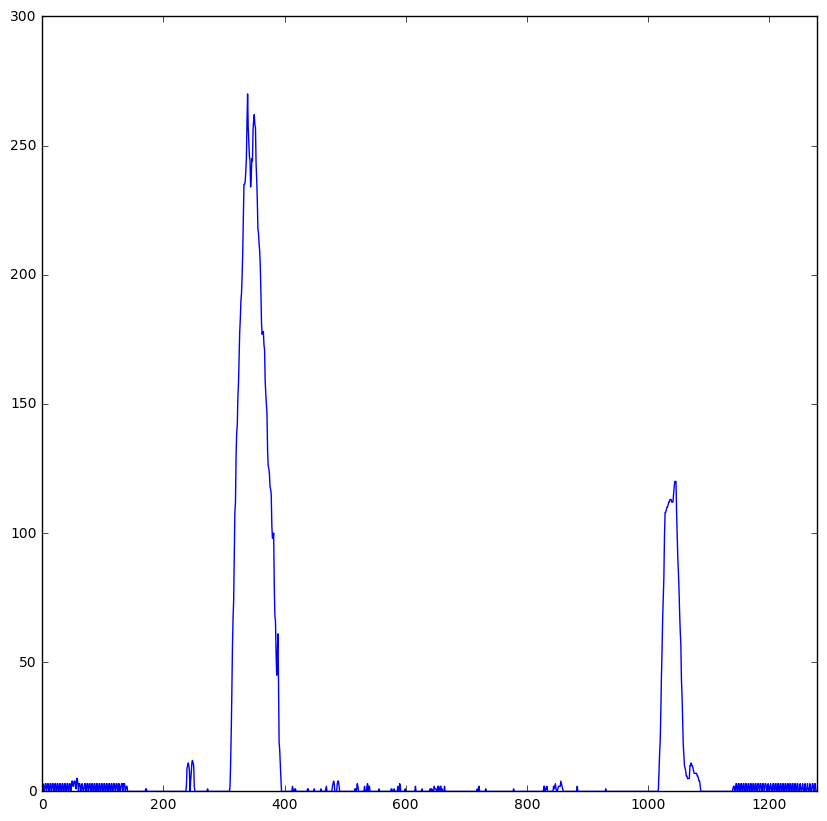

In [9]:
def get_starting_x(img, visualize=False):
    # Compute histogram
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
    
    if visualize:
        plt.plot(histogram);
        plt.autoscale(enable=True, axis='x', tight=True);
        plt.savefig(os.path.join(get_doc_dir(), 'line_search_initial_point.jpg'))
        
    # Get left and right peaks. Assuming that left and right
    # lines will be on the left or right half of the image
    x_half = int(len(histogram)/2)
    x0_left  = np.argmax(histogram[0:x_half])
    x0_right = x_half + np.argmax(histogram[x_half:])
    
    return x0_left, x0_right

# testing the previous code using the testing image
test_img = './test_images/test3.jpg'
img_original = mpimg.imread(test_img) 
img = undistort_img(img_original)
img_warped, M, Minv = get_birds_eye_view(img);
img_mask,_ = combined_mask(img_warped)
plt.figure();
plt.imshow(img_mask, cmap='gray');
plt.title('Masked, warped image');
plt.figure();
x0_left, x0_right = get_starting_x(img_mask, visualize = True)
save_doc_img(mask_to_rgb(img_mask), 'before_line_search')

In [22]:
# class implementation for Line, Lane and Slidingwindow

In [10]:
class Line():
    def __init__(self):
        # X-Y coordinates of the associated pixels, as a Nx2 vector
        self.pixels_x = []
        self.pixels_y = []
        
        # Degree of the polynomial that fits the line
        self.polynomial_deg = 2

        # Coefficients describing the line, in pixel coordinates
        self.coeffs = np.zeros(self.polynomial_deg)
       
        # Coefficients describing the line, in meters
        self.coeffs_m = np.zeros(self.polynomial_deg)

        self.ym_per_pix = 30/720  # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        
    def fit(self):
        # Fit in pixels
        self.coeffs = np.polyfit(self.pixels_y, self.pixels_x, self.polynomial_deg)

        # Fit in meters       
        self.coeffs_m = np.polyfit(self.ym_per_pix * np.array(self.pixels_y),
                                   self.xm_per_pix * np.array(self.pixels_x),
                                   self.polynomial_deg)       
    
    def update(self, pixels_x, pixels_y):
        self.pixels_x = pixels_x
        self.pixels_y = pixels_y
        self.fit()    
    
    def curvature(self, y_pos_pixels):
        y = y_pos_pixels * self.ym_per_pix
        dx_dy   = 2. * self.coeffs_m[0] * y + self.coeffs_m[1]
        d2x_dy2 = 2. * self.coeffs_m[0]
        curvature = ((1. + (dx_dy)**2)**1.5) / np.absolute(d2x_dy2)
        return curvature
    
    # return the value in meter
    def get_x_position(self, y_pixels, img_width):
        x_pixels = self.coeffs[0]*(y_pixels**2) + self.coeffs[1]*y_pixels + self.coeffs[2] \
                   - float(img_width)/2
        return self.xm_per_pix * x_pixels  
    
    def is_valid(self):
        # Check that coefficients are not all zero
        coeffs_ok = np.any(self.coeffs)
        
        return coeffs_ok
    
    def is_similar_to(self, line):
        # All coefficients except for the last one should be similar
        for i in range(len(self.coeffs) - 1):
            c_i_self = self.coeffs[i]
            c_i_other = line.coeffs[i]
            
            r = c_i_self / c_i_other
            r = max(r, 1.0/r)
            # if the difference is too big, return false
            if r > 2.0:
                return False
        return True
    
class Lane():
    def __init__(self):
        self.line_l = Line()
        self.line_r = Line()
    
    # check if the coefficient of all lines are zero, if all the coefficients are zero
    # return false
    def sanity_check(self):
        output = True
        
        # Lines are valid
        if not (self.line_l.is_valid() and self.line_r.is_valid()):
            output = False
        
        # Similar lines
        if not self.line_l.is_similar_to(self.line_r):
            output = False
        return output    
    
class SlidingWindow():
    # size of sliding window and initial searching points
    def __init__(self, size_x, size_y, x0, y0):
        self.size_x = size_x
        self.size_y = size_y
        self.x0 = x0
        self.y0 = y0
    
    # collect pixels in the sliding window
    def get_pixels(self, img):
        pixels_x = []
        pixels_y = []
        
        for x in range(max(0, self.x0), min(img.shape[1], self.x0 + self.size_x)):
            for y in range(max(0, self.y0), min(img.shape[0], self.y0 + self.size_y)):
                if (img[y, x]):
                    pixels_x.append(x)
                    pixels_y.append(y)
                    
        return pixels_x, pixels_y
                    
    def slide(self, delta_x, delta_y):
        self.x0 = self.x0 + delta_x
        self.y0 = self.y0 + delta_y
                    
    def is_point_in_img(self, img, x, y):
        if (x >= 0) and (x < img.shape[1]) and \
           (y >= 0) and (y < img.shape[0]):
            return True
        else:
            return False
    
    # check if the four vertices are in the image
    def is_inside_img(self, img):
        if self.is_point_in_img(img, self.x0,               self.y0)               or \
           self.is_point_in_img(img, self.x0 + self.size_x, self.y0)               or \
           self.is_point_in_img(img, self.x0,               self.y0 + self.size_y) or \
           self.is_point_in_img(img, self.x0 + self.size_x, self.y0 + self.size_y):
            return True
        else:
            return False
    
    def draw_in_img(self, img):
        points = [(self.x0, self.y0),
                  (self.x0, self.y0 + self.size_y),
                  (self.x0 + self.size_x, self.y0 + self.size_y),
                  (self.x0 + self.size_x, self.y0)]
        
        for i in range(len(points)):
            cv2.line(img, points[i], points[(i + 1)%len(points)], color = (255, 0, 0), thickness = 2)

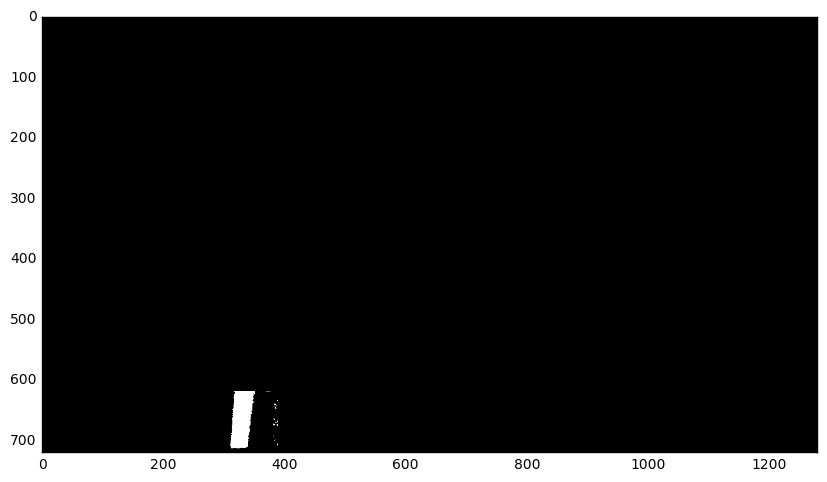

In [11]:
def sliding_window_test(img, x0):
    window = SlidingWindow(100, 100, x0 - 50, img.shape[0] - 1 - 100)
    pixels_x, pixels_y = window.get_pixels(img)
    img_out = np.zeros_like(img)
    img_out[pixels_y, pixels_x] = 255
    plt.imshow(img_out, cmap='gray')
    
sliding_window_test(img_mask, x0_left)

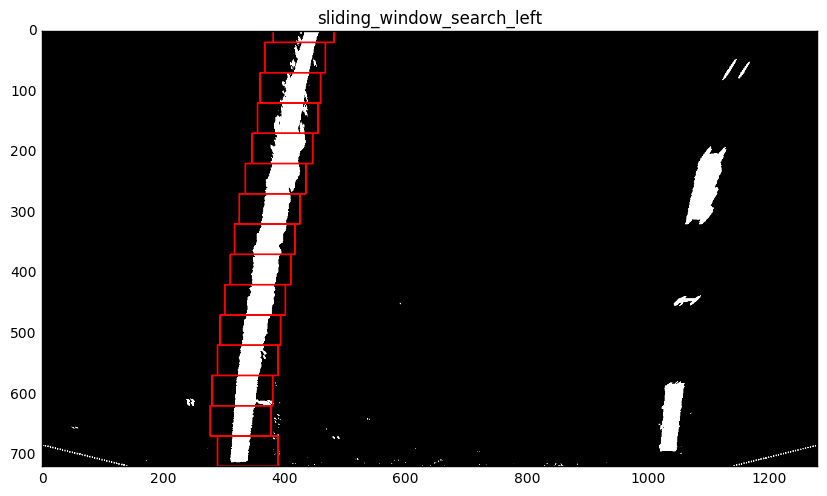

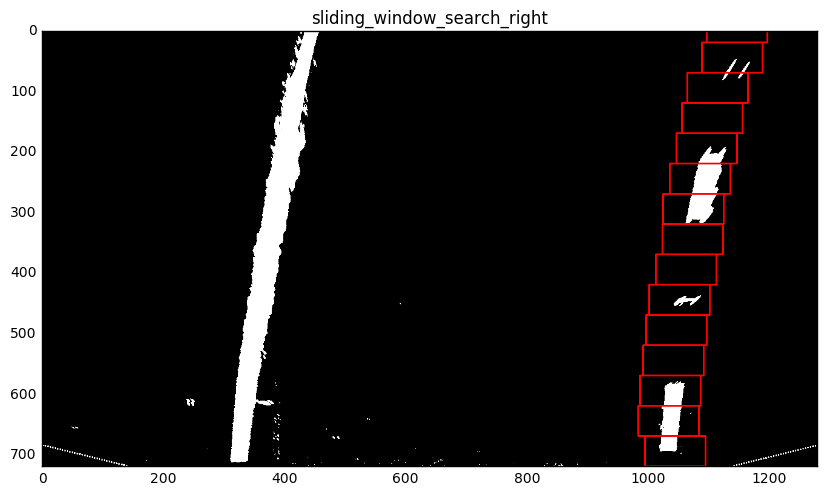

In [12]:
def get_line_points(img, line):
    n_points = 100
    yvals = np.linspace(0, n_points, num=n_points + 1) * (float(img.shape[0]) / float(n_points))
    xvals = line.coeffs[0]*yvals**2 + line.coeffs[1]*yvals + line.coeffs[2]   
    # curvefit the points based on the coefficients of previous calculated
    return xvals, yvals

def get_line_pixels(img_masked, x0, visualize = None):
    # Initialize sliding window and line
    size_x = 100
    size_y = 50
    window = SlidingWindow(size_x, size_y, x0 - size_x // 2, img_masked.shape[0] - size_y)

    pixels_x_out = []
    pixels_y_out = []
    
    if visualize:
        vis_img = 255 * np.copy(img_masked)
        vis_img = np.dstack((vis_img, vis_img, vis_img))
    
    # Go from bottom to top to find the line:
    done = False
    delta_x = 0
    
    while not done:
        # Visualize sliding window
        if visualize:
            window.draw_in_img(vis_img)  
            
        # Get pixels in the sliding window
        pixels_x, pixels_y = window.get_pixels(img_masked)
        
        # Add to line
        pixels_x_out = pixels_x_out + pixels_x
        pixels_y_out = pixels_y_out + pixels_y
        
        # Determine where to place the bounding box next. If we don't find pixels
        # in x, we move the previous delta_x assuming that the curvature is the same
        if pixels_x:
            mean_x = int(np.mean(pixels_x))            
            delta_x = (mean_x - size_x // 2) - window.x0            
        
        delta_y = -window.size_y          
        # Move sliding window
        window.slide(delta_x, delta_y)
        
        # We are done if the window is out of the image
        if not window.is_inside_img(img_masked):
            done = True

    if visualize:
        plt.figure();
        plt.imshow(vis_img)
        plt.title(visualize)
        save_doc_img(vis_img, visualize)

    return pixels_x_out, pixels_y_out

get_line_pixels(img_mask, x0_left, 'sliding_window_search_left');
get_line_pixels(img_mask, x0_right, 'sliding_window_search_right');

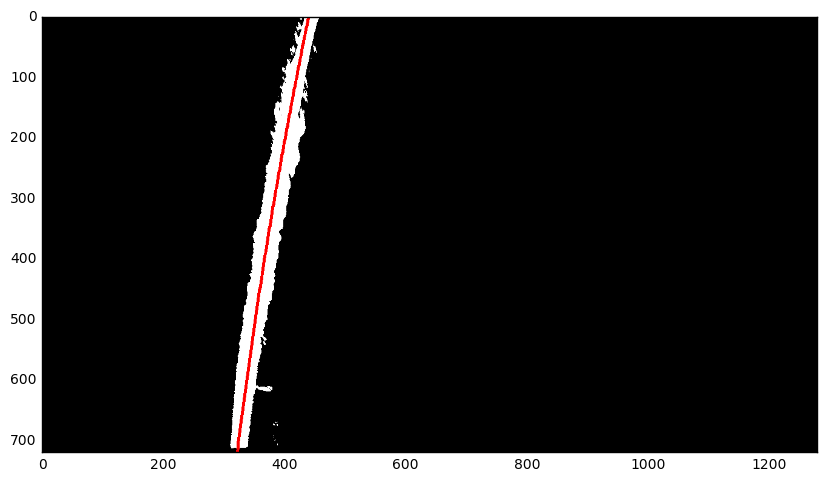

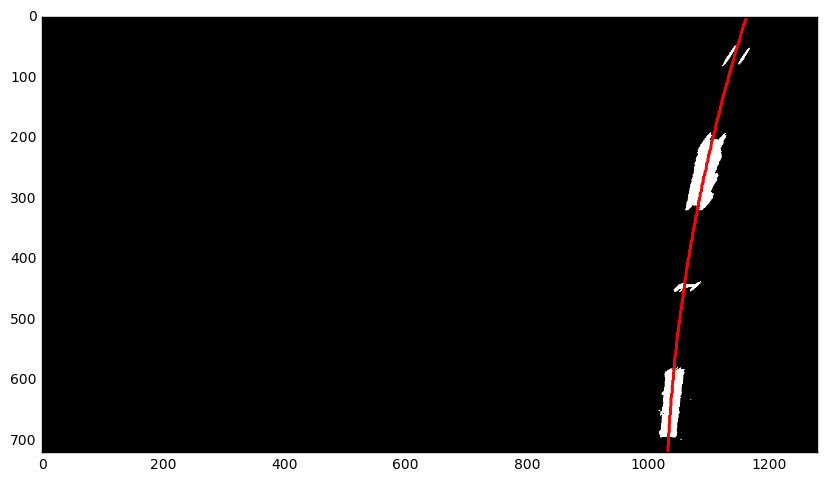

In [13]:
def draw_line(img, line, color = (255,0,0), thickness = 4):
    # Get line points, polynominal points from curvefit
    xvals, yvals = get_line_points(img, line)  

    # Draw line
    for i in range(len(yvals) - 1):
        p1 = (int(xvals[i  ]), int(yvals[i  ]))
        p2 = (int(xvals[i+1]), int(yvals[i+1]))
        # draw the line of the curvefit points
        cv2.line(img, p1, p2, color=color, thickness=thickness)   
    return img

def get_line_from_x0(img_masked, x0):
    pixels_x, pixels_y = get_line_pixels(img_masked, x0)
    line = Line()
    line.pixels_x = pixels_x
    line.pixels_y = pixels_y
    # calculate the coefficients
    line.fit() 
    return line

def line_test(img, x0):
    line = get_line_from_x0(img, x0)
    
    img_out = np.zeros_like(img)
    img_out[line.pixels_y, line.pixels_x] = 255

    # Convert to RGB image
    img_out = cv2.cvtColor(img_out, cv2.COLOR_GRAY2RGB)

    # Draw a line representing the fit polynomial
    img_out = draw_line(img_out, line)
    
    plt.figure()            
    plt.imshow(img_out)
    return img_out

save_doc_img(line_test(img_mask, x0_left), 'line_fit_left')
save_doc_img(line_test(img_mask, x0_right), 'line_fit_right')

# get 2 lines from two different points and construct the lane object
def extract_lane(img_mask):
    # Get starting position for search
    x0_left, x0_right = get_starting_x(img_mask)
    
    # Get the lines from the mask and starting position, x0
    line_l = get_line_from_x0(img_mask, x0_left)
    line_r = get_line_from_x0(img_mask, x0_right)

    # Draw chosen pixels for debug
    lane_pixels_img = np.zeros_like(img_mask)
    lane_pixels_img[line_l.pixels_y, line_l.pixels_x] = 1
    lane_pixels_img[line_r.pixels_y, line_r.pixels_x] = 1
    
    # Encapsulate them into a Lane
    lane = Lane()
    lane.line_l = line_l
    lane.line_r = line_r
    
    return lane, lane_pixels_img

def draw_free_space(img, lane, color = (0, 255, 0)):
    # Get line points
    xvals_l, yvals_l = get_line_points(img, lane.line_l)
    xvals_r, yvals_r = get_line_points(img, lane.line_r)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    # we do the transpose because the image is like transpose form of array
    
    pts_left = np.array([np.transpose(np.vstack([xvals_l, yvals_l]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([xvals_r, yvals_r])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw into image
    cv2.fillPoly(img, np.int_([pts]), color)

    # Return
    return img




In [14]:
def generate_output_img(img_original, lane, curvature, lane_offset):
    # Copy warped image
    img_lines = np.zeros_like(img_original)
    img_free_space = np.zeros_like(img_original)

    # Draw lines
    draw_line(img_lines, lane.line_l, thickness = 50)
    draw_line(img_lines, lane.line_r, thickness = 50)    

    # Draw free space
    draw_free_space(img_free_space, lane)
    
    # Unwarp images
    img_free_space_unwarp = cv2.warpPerspective(img_free_space, Minv, (img_original.shape[1], img_original.shape[0])) 
    img_lines_unwarp = cv2.warpPerspective(img_lines, Minv, (img_original.shape[1], img_original.shape[0])) 

    # Blend with original image
    img_out = cv2.addWeighted(img_original, 1, img_lines_unwarp, 0.3, 0)
    img_out = cv2.addWeighted(img_out, 1, img_free_space_unwarp, 0.3, 0)
    
    # Print curvature and lane offset
    font = cv2.FONT_HERSHEY_SIMPLEX
    color = (255, 255, 255)
    scale = 2
    thickness = 2
    if np.sign(lane_offset) > 0:
        vehicle_side = 'left'
    else:
        vehicle_side = 'right'
        
    cv2.putText(img_out, "Road curvature: %.1f m" % curvature, (100, 50), font, scale, color, thickness)
    cv2.putText(img_out, "Vehicle is %.1f m %s of center" % (np.absolute(lane_offset), vehicle_side), 
                (100, 100), font, scale, color, thickness)    
    
    return img_out, img_lines

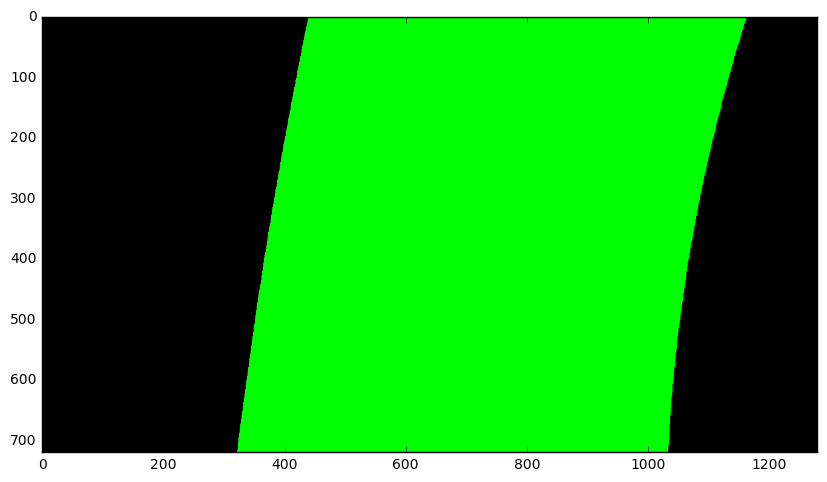

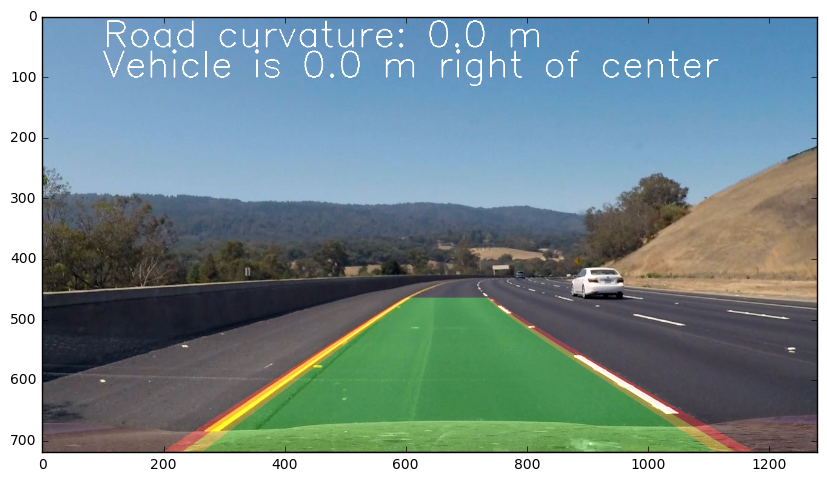

In [15]:
line_l = get_line_from_x0(img_mask, x0_left)
line_r = get_line_from_x0(img_mask, x0_right)

lane = Lane()
lane.line_l = line_l
lane.line_r = line_r

img_free_space_test = np.zeros_like(img_mask)
img_free_space_test = np.dstack((img_free_space_test, img_free_space_test, img_free_space_test))
plt.figure();
plt.imshow(draw_free_space(img_free_space_test, lane));
save_doc_img(draw_free_space(img_free_space_test, lane), 'free_space')
img_output, _ = generate_output_img(img_original, lane, 0, 0)
plt.figure();
plt.imshow(img_output);
save_doc_img(img_output, 'main_visualization')

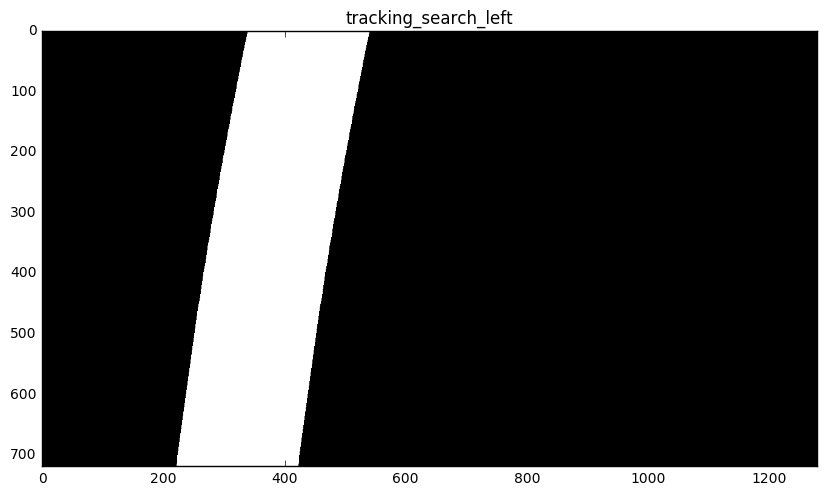

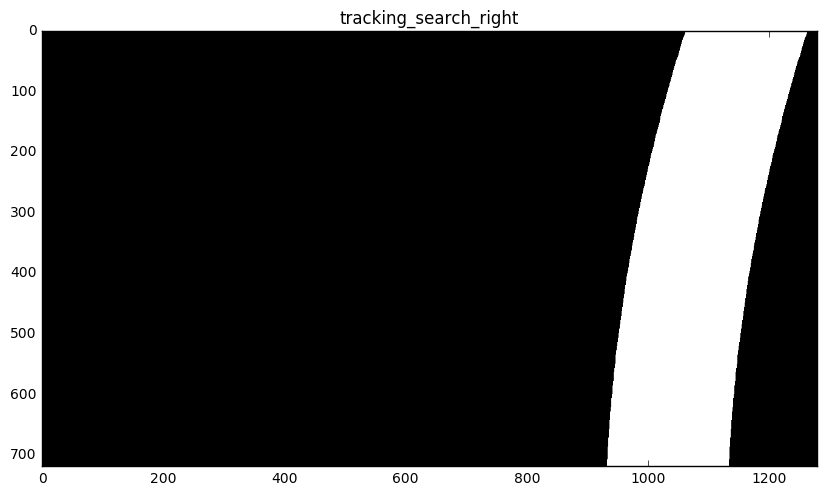

In [16]:
class LineTracker(object):
    def __init__(self, line, visualization_name = None):
        self.line = line
        self.visualization_name = visualization_name
    
    # define a searching area by defining the shifting value of line
    def track(self, img_warped):
        # Define search mask
        search_mask = self._create_search_mask(img_warped)
        
        # Mask image
        img_warped_masked = search_mask * img_warped        
        
        # Get line pixels
        points = np.squeeze(cv2.findNonZero(img_warped_masked))
        pixels_x = points[:,0]
        pixels_y = points[:,1]
            
        # Create debug img
        img_line_pixels = np.zeros_like(img_warped)
        # pixels should be switch positions when employed in matrix
        img_line_pixels[pixels_y, pixels_x] = 1
            
        # Update line
        self.line.update(pixels_x, pixels_y)
        
        return img_line_pixels
        
    def _create_search_mask(self, img_warped):
        mask = np.zeros_like(img_warped)
        
        # Create lines to left and right of the actual line, with some offset
        offset = 100 # pixels
        
        fake_lane = Lane()
        fake_lane.line_l = self._offset_line_x(self.line, -offset)
        fake_lane.line_r = self._offset_line_x(self.line, offset)
        
        # Draw as in free space
        draw_free_space(mask, fake_lane, color = (1, 1, 1))        
        
        if self.visualization_name:
            plt.figure();
            plt.imshow(mask, cmap = 'gray')
            plt.title(self.visualization_name)
            save_doc_img(mask_to_rgb(mask), self.visualization_name)
        return mask
            
    def _offset_line_x(self, line, offset):
        # Copy line
        line_out = Line()
        line_out.coeffs = np.copy(line.coeffs)
        
        # Apply offset to the last coefficient, which will not influence the 
        # value of slope
        line_out.coeffs[-1] = line_out.coeffs[-1] + offset
        return line_out

lt = LineTracker(line_l, 'tracking_search_left')
lt.track(img_mask);

lt = LineTracker(line_r, 'tracking_search_right')
lt.track(img_mask);

In [20]:
def track_lane(lane, img_mask):
    lt_l = LineTracker(lane.line_l)
    img_line_pixels_l = lt_l.track(img_mask)
    lt_r = LineTracker(lane.line_r)
    img_line_pixels_r = lt_r.track(img_mask)    
    img_line_pixels = cv2.bitwise_or(img_line_pixels_l, img_line_pixels_r)
    return lane, img_line_pixels

# the overall curvature is the average of the sum of the two line
# the point for calculation is at the bottom of the image
def compute_curvature(lane, img_shape):
    y_curvature = img_shape[0]
    return 0.5 * (lane.line_l.curvature(y_curvature) + lane.line_r.curvature(y_curvature))

def create_debug_img(result_img, img_warped, img_mask, intermediate_masks, img_line_pixels, 
                     img_lines, curvature, vehicle_position):
    # Declare output image, full HD
    img_out = np.zeros((1080, 1920, 3), dtype = np.uint8)
    
    # Result image
    img_out[0:720, 0:1280,     :] = cv2.resize(result_img, (1280, 720))
    
    # Warped image
    img_out[720:960, 0:320, :]    = cv2.resize(img_warped, (320,240))
    
    # Final mask
    img_out[720:960, 320:640 , :] = cv2.resize(mask_to_rgb(img_mask), (320, 240))
    
    # Intermediate masks
    sx = 320
    sy = 240
    for i, mask_i in enumerate(intermediate_masks):        
        idx_x = i % 2
        idx_y = i // 2
        
        p0_x = 1280 + idx_x * sx
        p0_y = 0    + idx_y * sy
        
        img_out[p0_y:p0_y + sy, p0_x:p0_x + sx, :] = cv2.resize(mask_to_rgb(mask_i), (sx, sy))        

    # Pixels belonging to lane lines
    img_out[720:960, 640:960 , :] = cv2.resize(mask_to_rgb(img_line_pixels), (320, 240))    
    
    # Lines before warping
    img_out[720:960, 960:1280 , :] = cv2.resize(img_lines, (320, 240))    
    
    return img_out

# assume the position of camera is at the center of vehicle, 
# that is, we calculate the average
def compute_vehicle_position(lane, img_shape):
    return 0.5 * (lane.line_r.get_x_position(img_shape[0], img_shape[1]) + \
                  lane.line_l.get_x_position(img_shape[0], img_shape[1]))



In [21]:
class LaneFindingPipeline:
    def __init__(self, debug = False):
        self.lane = Lane()
        self.debug = debug
        
    def run(self, img):
        # Undistort image
        img_undistort = undistort_img(img)

        # Get birds-eye view
        img_warped, M, Minv = get_birds_eye_view(img_undistort)

        # Mask using color and gradients
        img_mask, intermediate_masks = combined_mask(img_warped)

        # Extract lines
        if not self.lane.sanity_check():
            self.lane, img_line_pixels = extract_lane(img_mask)
        else:
            self.lane, img_line_pixels = track_lane(self.lane, img_mask)
            
        # Compute curvature and vehicle position
        curvature = compute_curvature(self.lane, img.shape)
        vehicle_position = compute_vehicle_position(self.lane, img.shape)

        # Create output image
        img_out, img_lines = generate_output_img(img, self.lane, curvature, vehicle_position)        

        # Return
        if self.debug:
            img_out = create_debug_img(img_out, img_warped, img_mask, intermediate_masks, 
                                       img_line_pixels, img_lines, curvature, vehicle_position)
            
        return img_out

In [22]:
test_videos = glob.glob('./project_video.mp4')

for video in test_videos:
    # Create LaneFindingPipeline
    pipeline = LaneFindingPipeline(debug = use_debug())
    
    # Read video
    clip = VideoFileClip(video)
    
    # Process video
    clip_processed = clip.fl_image(pipeline.run) #NOTE: this function expects color images!!
    
    # Save to disk
    _,video_name = os.path.split(video)
    out_name = os.path.join(get_output_dir(), video_name)
    clip_processed.write_videofile(out_name, audio=False)
    
    # Display in the notebook
    print(out_name)
    display(HTML("""<video width="640" height="360" controls><source src="{0}"></video>""".format(out_name)))

[MoviePy] >>>> Building video ./output_images/project_video.mp4
[MoviePy] Writing video ./output_images/project_video.mp4


100%|█████████▉| 1260/1261 [04:11<00:00,  4.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video.mp4 

./output_images/project_video.mp4
